
# 🧪 Customer Support Classifier — Dataset Exploration (Week 1)

**Goal:** Quick, reproducible exploration of the `customer_support_tickets_clean_500.csv` dataset.

**What you'll do in this notebook:**
1. Load the dataset from `data/`
2. Inspect schema & basic stats
3. Check class distribution
4. Preview random samples per class
5. Look at text length distribution
6. (Optional) Quick train/test split sanity check

> Run this notebook in Google Colab or locally inside the repo.


In [2]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

# Ensure plots show inline
%matplotlib inline


In [3]:

# === Config ===
DATA_PATH = "data/customer_support_tickets_clean_500.csv"  # adjust if needed
RANDOM_SEED = 42

# Reproducibility
np.random.seed(RANDOM_SEED)


In [5]:

assert os.path.exists(DATA_PATH), f"Could not find file at {DATA_PATH}. Make sure the CSV is in the data/ folder."
df = pd.read_csv(DATA_PATH)

print("✅ Loaded dataset.")
print("Shape:", df.shape)
df.head()


✅ Loaded dataset.
Shape: (520, 4)


,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,Othr,1000,Dana
1,Can I migrate data from Freshdesk?,Othr,1001,Bob
2,Cannot update billing address; page keeps relo...,billing,1002,Charlie
3,Looking for a product roadmap or upcoming feat...,other,1003,Dana
4,Dark mode toggled but UI stays light.,Tech-support,1004,Alice


In [6]:

print("Columns:", df.columns.tolist())
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())


Columns: ['text', 'label', 'ticket_id', 'agent_name']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        495 non-null    object
 1   label       495 non-null    object
 2   ticket_id   520 non-null    int64 
 3   agent_name  520 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.4+ KB
None

Missing values per column:
text          25
label         25
ticket_id      0
agent_name     0
dtype: int64


In [7]:

# Try to normalize expected columns if they exist with different names
# Expected: 'text' and 'label'
candidate_text_cols = [c for c in df.columns if c.lower() in ["text", "ticket_text", "message", "body"]]
candidate_label_cols = [c for c in df.columns if c.lower() in ["label", "category", "class"]]

if candidate_text_cols and "text" not in df.columns:
    df = df.rename(columns={candidate_text_cols[0]: "text"})
if candidate_label_cols and "label" not in df.columns:
    df = df.rename(columns={candidate_label_cols[0]: "label"})

print("Using columns: text ->", "text" in df.columns, ", label ->", "label" in df.columns)
display(df.head(3))


Using columns: text -> True , label -> True


,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,Othr,1000,Dana
1,Can I migrate data from Freshdesk?,Othr,1001,Bob
2,Cannot update billing address; page keeps relo...,billing,1002,Charlie


Class distribution:
label
 Account        22
 Tech           41
ACCOUNT         37
Accnt           42
BILLING         25
Billing         34
Billng          35
OTHER           28
Other           33
Othr            35
TECHNICAL       31
Tech-support    21
account         21
billing         26
other           32
technical       32
Name: count, dtype: int64


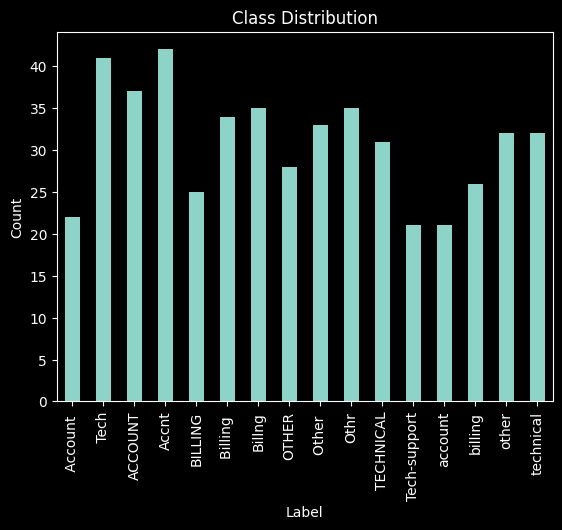

In [8]:

if "label" in df.columns:
    counts = df["label"].value_counts().sort_index()
    print("Class distribution:")
    print(counts)

    # Plot class distribution
    plt.figure()
    counts.plot(kind="bar")
    plt.title("Class Distribution")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()
else:
    print("No 'label' column found; please ensure your CSV has a label/category column.")


Text length (words) — summary stats:
count    520.000000
mean       7.190385
std        1.780948
min        1.000000
25%        7.000000
50%        7.000000
75%        8.000000
max       11.000000
Name: text, dtype: float64


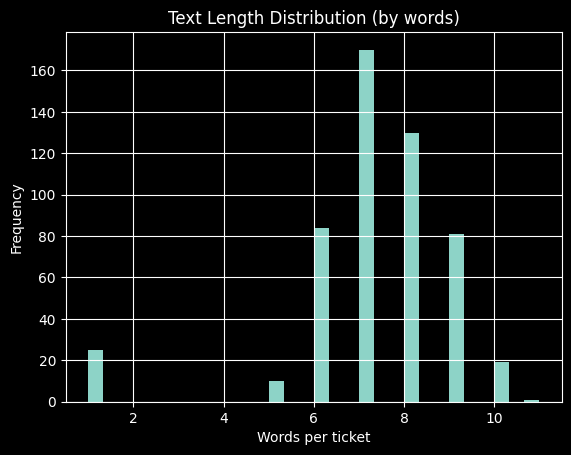

In [9]:

if "text" in df.columns:
    text_lengths = df["text"].astype(str).apply(lambda x: len(x.split()))
    print("Text length (words) — summary stats:")
    print(text_lengths.describe())

    plt.figure()
    text_lengths.hist(bins=30)
    plt.title("Text Length Distribution (by words)")
    plt.xlabel("Words per ticket")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No 'text' column found; please ensure your CSV has a text column.")


In [10]:

if set(["text","label"]).issubset(df.columns):
    def sample_per_class(dataframe, col_label="label", n=3):
        samples = []
        for cls, group in dataframe.groupby(col_label):
            s = group.sample(min(n, len(group)), random_state=RANDOM_SEED)[["text", col_label]]
            s.insert(0, "sample_of", cls)
            samples.append(s)
        return pd.concat(samples, ignore_index=True)

    samples_df = sample_per_class(df, "label", n=3)
    display(samples_df)
else:
    print("Skipping samples per class — missing 'text' or 'label'.")


,sample_of,text,label
0,Account,Incorrect role assigned; need admin access for...,Account
1,Account,Cannot enable two-factor authentication; QR fa...,Account
2,Account,How do I delete my account and all data?,Account
3,Tech,File export to CSV generates corrupted file.,Tech
4,Tech,Live chat widget not loading on homepage.,Tech
5,Tech,Search results page is blank after entering a ...,Tech
6,ACCOUNT,Can't verify phone number; code not sent.,ACCOUNT
7,ACCOUNT,Locked out after too many login attempts. ###,ACCOUNT
8,ACCOUNT,Profile picture upload fails with unknown erro...,ACCOUNT
9,Accnt,Cannot enable two-factor authentication; QR fa...,Accnt


In [15]:
#Clean up , standardize and fix the labels
# Drop rows where label is missing
df = df.dropna(subset=["label"])

# Clean and normalize labels
df["label"] = (
    df["label"]
    .str.strip()          # remove extra spaces
    .str.lower()          # lowercase everything
    .replace({
        "billng": "billing",
        "billing ": "billing",
        "tech": "technical",
        "tech-support": "technical",
        "accnt": "account",
        "account ": "account",
        "othr": "other",
        "other ": "other",
        "other": "other",
        "other": "other",
        "technical": "technical",
        "billing": "billing",
        "account": "account"
    })
)

# Double-check unique labels now
print("Cleaned label categories:", df["label"].unique())
print("Remaining NaN:", df["label"].isna().sum())


Cleaned label categories: ['other' 'billing' 'technical' 'account']
Remaining NaN: 0


C:\Users\sedem\AppData\Local\Temp\ipykernel_10136\2342529533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = (


In [16]:
import re
import html

def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    text = html.unescape(text)  # Decode HTML entities like &amp;
    text = text.lower()  # Normalize casing
    text = re.sub(r"http\S+|www\S+", " ", text)  # Remove URLs
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)  # Remove @mentions
    text = re.sub(r"#[A-Za-z0-9_]+", " ", text)  # Remove hashtags
    text = re.sub(r"[^\w\s.,!?']", " ", text)  # Remove emojis/symbols
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces
    return text.strip()

# Apply cleaning to the 'text' column
df["text"] = df["text"].apply(clean_text)

# Verify results
print(df["text"].sample(5).tolist())


['can i migrate data from zendesk? !!!', 'website returns 500 error on checkout.', 'subscription renewal charged incorrectly this month.', 'looking for a product roadmap or upcoming features.', 'search results page is blank after entering a query.']


C:\Users\sedem\AppData\Local\Temp\ipykernel_10136\3886642937.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df["text"].apply(clean_text)


In [18]:

if set(["text","label"]).issubset(df.columns):
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=RANDOM_SEED)
    print("Train shape:", train_df.shape, "Test shape:", test_df.shape)

    # Verify stratification
    print("\nTrain class distribution:")
    print(train_df["label"].value_counts(normalize=True).sort_index())

    print("\nTest class distribution:")
    print(test_df["label"].value_counts(normalize=True).sort_index())
else:
    print("Skipping split — missing 'text' or 'label'.")


Train shape: (396, 4) Test shape: (99, 4)

Train class distribution:
label
account      0.247475
billing      0.242424
other        0.257576
technical    0.252525
Name: proportion, dtype: float64

Test class distribution:
label
account      0.242424
billing      0.242424
other        0.262626
technical    0.252525
Name: proportion, dtype: float64


In [19]:

# Save processed artifacts (optional)
import os
os.makedirs("artifacts", exist_ok=True)
df.head(50).to_csv("artifacts/sample_preview.csv", index=False)
print("Saved artifacts/sample_preview.csv")


Saved artifacts/sample_preview.csv



---

**Notes for interns:**  
- If your CSV uses different column names, adjust the rename cell accordingly.  
- Keep your environment consistent (Python 3.9+).  
- Push your findings as a short markdown summary in the repo (`reports/week1_summary_yourname.md`).

_Last updated: 2025-10-03 15:23 UTC_
